In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import os

In [2]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

/home/zafar/.pyenv/versions/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


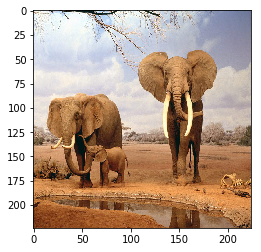

In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

img_path = './data/elephants_2.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

plt.imshow(img)

In [4]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0]))

('Predicted:', [(u'n02504458', u'African_elephant', 0.8045282), (u'n02504013', u'Indian_elephant', 0.1503784), (u'n01871265', u'tusker', 0.034076765)])
386


In [25]:
import keras.backend as K

african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for idx in range(512):
    conv_layer_output_value[:, :, idx] *= pooled_grads_value[idx]
heatmap = np.mean(conv_layer_output_value, axis=-1)

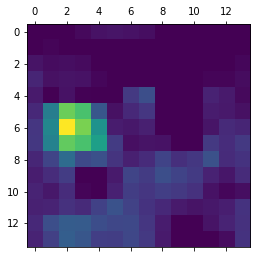

In [26]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [50]:
import cv2

img = cv2.imread(img_path)
heatmap1 = cv2.resize(heatmap, (img.shape[1], img.shape[0])) >= 0.3
heatmap1 = np.uint8(255 * heatmap1)
heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_BONE)
superimposed_img = np.uint8(heatmap1 * 0.4 + img * 0.6)
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

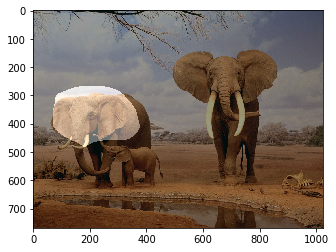

In [51]:
plt.imshow(superimposed_img)